# Dev notebook for updates

`Lanczos optimization`

In [6]:
import numpy as np
from dmrg_src.MPS_optimized import MPS_InMemory as MPS
from dmrg_src.MPO import MPO_TFI
from dmrg_src.cont import CONT
from dmrg_src.dmrg import dmrg
from dmrg.obs import observables

import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm

### Class 

In [14]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
from scipy.sparse.linalg import ArpackNoConvergence


class EffH():

    def __init__(self,L,R,H,site,k=300):
        self.L = L 
        self.R = R 
        self.H = H 
        self.k = k
        self.d = H.d
        self.site = site
        c1,_,_ = L.shape
        c2,_,_ = R.shape
        self.c1 = c1
        self.c2 = c2
        self.len_vec = c1*c2*self.d**2
        self.k = min(c1*c2*self.d**2,k)

    def __str__(self):
        return 'Effective Hamiltonian on the Cayley tree'
    
    def __repr__(self):
        return 'Effective Hamiltonian on the Cayley tree'

    def matvec(self,psi):
        h = self.H
        psi = np.reshape(psi,(self.c1,self.d,self.d,self.c2))
        
        x = np.tensordot(self.L,h.mpo(p=self.site),(1,2))
        x = np.tensordot(x,psi,[(0,2),(0,1)])
        x = np.tensordot(x,h.mpo(p=self.site+1),[(2,3),(2,0)])
        x = np.tensordot(x,self.R,[(4,2),(1,0)])
        
        return np.reshape(x,(self.c1*self.d*self.d*self.c2))
    
    def lanc_iter(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if beta  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) - beta*vecs[-2]
            alpha = psi.conj()@vecs[-1]
            psi = psi - alpha * vecs[-1] 
            T[i, i] = alpha.real
            T[i-1, i] = T[i, i-1] = beta    
        
        return T, (np.array(vecs).T).conj()

    def lanc_iter_old(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if beta  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) 
            alpha = np.inner(vecs[-1].conj(), psi).real
            psi = psi - alpha * vecs[-1] - beta * vecs[-2]
            T[i, i] = alpha
            T[i-1, i] = T[i, i-1] = beta    
        return T, np.array(vecs).T

    def lanc_iter_new(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if np.abs(beta)  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) 
            alpha = np.inner(vecs[-1].conj(), psi).real
            psi = psi - alpha * vecs[-1] - beta * vecs[-2]
            T[i, i] = alpha
            T[i-1, i] = T[i, i-1] = beta    
        return T, np.array(vecs).T

    def lanczos_grd(self,psi0=None,exc='off'):
        if psi0 is None:
            psi0 = np.random.rand(self.c1*self.c2*self.d**2)
        T, vecs = self.lanc_iter_old(psi0,exc=exc)

        try:
            E,v = eigh_tridiagonal(np.diag(T),np.diag(T,k=1),select='i',select_range=(0,2))
            # E,v = np.linalg.eigh(T)
            result = vecs @ v[:, np.argmin(E)]
            if exc == 'off':
                E = min(E)
                
        except ArpackNoConvergence as err:
            print('Lanczos did not converge !!!')
            E = psi0.conj()@self.matvec(psi0)
            result = psi0

        return E, result

In [12]:
import numpy as np
from scipy.linalg import svd

# from dmrg.MPS import MPS
# from dmrg.cont import CONT
# from .lanczos import EffH

class dmrg():
    """
        Class that runs the DMRG algorithm on a 1 dimensional system

            Attributes:
                - cont: Class DMRG.contractions
    """

    def __init__(self,cont,chi=100,cut=1e-12,k=100):
        self.cont = cont
        self.mps = cont.mps
        self.chi = chi
        self.h = cont.h
        self.L = cont.L
        self.count = cont.count
        self.cut = cut
        self.d = self.mps.d
        self.k = k

    
    def infinite(self):

        En = np.zeros(self.L//2-1)
        
        env_left = self.cont.left(self.L%2)
        env_right = self.cont.right(self.L-1)

        for i in range(1,self.mps.L//2):

            H = EffH(env_left,env_right,self.h,site=i)
            En[i-1],grd = H.lanczos_grd()

            mat = np.reshape(grd,(H.c1*H.d,H.d*H.c2))
            l,c,r = svd(mat,full_matrices=False)

            bound = min(len(c[c>self.cut]),self.chi)
           
            l = l[:,:bound]
            c = c[:bound]
            r = r[:bound,:]

            self.mps.write_left(i+self.L%2,l)
            self.mps.write_right(self.mps.L-i-1,r)
        
            env_left = self.cont.add(i+self.L%2,'l')
            env_right = self.cont.add(self.mps.L-i-1,'r')
            
        self.mps.writeS(i+self.L%2,np.diag(c))

        return En

    def step2sites(self,site,dir,exc='off',stage=None):

        # FIX: Use self.cont instead of undefined 'cont' variable
        env_left = self.cont.left(site-1)
        env_right = self.cont.right(site+2)
    
        H = EffH(env_left,env_right,self.h,site=site,k=self.k)

        if dir == 'l' or dir == 'bl':
            init_vec = np.tensordot(self.mps.read(site),np.tensordot(self.mps.read(site+1),self.mps.readS(site+1),(2,0)),(2,1))
            init_vec = dmrg.remish(init_vec)
        if dir == 'r' or dir == 'br':
            init_vec = np.tensordot(np.tensordot(self.mps.readS(site-1),self.mps.read(site),(0,1)),self.mps.read(site+1),(2,1))

        init_vec = np.reshape(init_vec,np.prod(init_vec.shape))

        grd_pre = 1/np.sqrt(init_vec@np.conj(init_vec))*init_vec
        En_pre = np.conj(grd_pre)@H.matvec(grd_pre)
        
        if stage == None:
            En,grd = H.lanczos_grd(psi0=None,exc=exc)
            grd_state = 1/np.sqrt(np.conj(grd)@grd)*grd
            
        if stage == 'Final':
            grd_state = 1/np.sqrt(init_vec@np.conj(init_vec))*init_vec
            En = np.conj(grd_state)@H.matvec(grd_state)

        grd_state = np.reshape(grd_state,(H.c1*H.d,H.d*H.c2))

        l,c,r = svd(grd_state,full_matrices=False)
        
        bound = min(len(c[c**2>self.cut]),self.chi)
        l = l[:,:bound]
        c = c[:bound]
        r = r[:bound,:]
        
        self.mps.write_left(site,l)
        self.mps.write_right(site+1,r)
        self.mps.writeS(site,np.diag(c))

        if dir == 'r':
            self.cont.add(site,'l')
            if site == self.L -3:
                self.cont.add(site+1,'r')
        
        if dir == 'l':
            self.cont.add(site+1,'r')
            if site == 1:
                self.cont.add(site,'l')
        
        return En, -c**2@np.log(c**2), En_pre


    def remish(ten):
        d0,d1,d2,d3 = ten.shape
        res = np.zeros((d1,d0,d2,d3),dtype='complex256')
        for i0 in range(d0):
            for i1 in range(d1):
                res[i1,i0,:,:] = ten[i0,i1,:,:]

        return res


### MPO

In [ ]:
class MPO_AL_test():

    Id2 = np.identity(2)
    Id4 = np.identity(4)
    Sp = np.array([[0,1],[0,0]])
    Sm = np.array([[0,0],[1,0]])
    Z = np.array([[1,0],[0,-1]])
    d = 4

    sub_BC = [0,2,3]
    sub_A = [1,4]

    def __init__(self,t_1,t_2,U,e_A,mu):
        self.t_1 = t_1
        self.t_2 = t_2
        self.U = U
        self.e_A = e_A
        self.mu = mu
        self.OP = [np.kron(self.Sm,self.Id2),np.kron(self.Sp,self.Id2),np.kron(self.Z,self.Sm),np.kron(self.Z,self.Sp)]
        self.coeff = [[self.t_1,self.t_2,self.t_2,0,0],
                    [self.t_1,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_1,self.t_2,0,self.t_2],
                    [0,self.t_1,0,0,self.t_2]]

    
    def mpo(self, p):
        # FIX: Use fixed bond dimensions (22x22), not variable dimensions
        MPO = np.zeros((4, 4, 22, 22), dtype='complex128')

        MPO[:,:,0,0] = self.Id4
        MPO[:,:,0,1] = np.kron(self.Sp,self.Z)
        MPO[:,:,0,6] = np.kron(self.Sm,self.Z)
        MPO[:,:,0,11] = np.kron(self.Id2,self.Sp)
        MPO[:,:,0,16] = np.kron(self.Id2,self.Sm)
        MPO[:,:,0,21] = -self.mu*(np.kron(self.Z,self.Id2) + np.kron(self.Id2,self.Z))

        # sublattice conditions
        if (p-1)%5 in self.sub_BC:
            MPO[:,:,0,21] += self.U*np.kron(self.Z,self.Z)
        
        if (p-1)%5 in self.sub_A:
            MPO[:,:,0,21] += self.e_A*(np.kron(self.Z,self.Id2) + np.kron(self.Id2,self.Z))

        for j in range(4):
            for i in range(4):
                MPO[:,:,1 +j*5 +i,2+j*5+i] = np.kron(self.Z,self.Z)

        
        for j in range(1,6):
            for i in range(4):
                MPO[:,:,j+5*i,21] = self.coeff[(p-1)%5][j-1]*self.OP[i]

        MPO[:,:,21,21] = self.Id4

        return MPO

    def Wl(self):

        Wleft = np.zeros((4,4,22), dtype='complex128')

        Wleft[:,:,0] = self.Id4
        Wleft[:,:,1] = np.kron(self.Sp,self.Z)
        Wleft[:,:,6] = np.kron(self.Sm,self.Z)
        Wleft[:,:,11] = np.kron(self.Id2,self.Sp)
        Wleft[:,:,16] = np.kron(self.Id2,self.Sm)
        Wleft[:,:,21] = (-self.mu + self.e_A )*(np.kron(self.Z,self.Id2) + np.kron(self.Id2,self.Z)) 

        return Wleft

    def Wr(self):

        Wright = np.zeros((4,4,22), dtype='complex128')

        for j in range(1,6):
            for i in range(4):
                Wright[:,:,j+5*i] = self.coeff[1][j-1]*self.OP[i]

        Wright[:,:,21] = self.Id4

        return Wright

In [10]:
class MPO_XY():

    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Id = np.identity(2)
    d = 2

    def __init__(self,J=1):
        self.J = J 

    def Wl(self,p=None):
        Wl = np.zeros((2,2,4),dtype='complex')

        Wl[:,:,0] = self.Id
        Wl[:,:,1] = self.X 
        Wl[:,:,2] = self.Y 

        return Wl 

    def mpo(self,p=None):

        MPO = np.zeros((2,2,4,4),dtype='complex')

        MPO[:,:,0,0] = self.Id 
        MPO[:,:,0,1] = self.X 
        MPO[:,:,0,2] = self.Y 
        
        MPO[:,:,1,3] = self.J*self.Y
        MPO[:,:,2,3] = self.J*self.X 
        
        MPO[:,:,3,3] = self.Id 

        return MPO 

    def Wr(self,p=None):

        Wr = np.zeros((2,2,4),dtype='complex')

        Wr[:,:,1] = self.J*self.Y
        Wr[:,:,2] = self.J*self.X 
        Wr[:,:,3] = self.Id 

        return Wr

In [11]:
class MPO_XY_big():

    X = np.kron(np.array([[0,1],[1,0]]),np.array([[1,0],[0,1]]))
    Y = np.kron(np.array([[0,-1j],[1j,0]]),np.array([[1,0],[0,1]]))
    Z = np.kron(np.identity(2),np.array([[1,0],[0,-1]]))
    Id = np.identity(4)
    d = 4

    def __init__(self,J=1):
        self.J = J 

    def Wl(self,p=None):
        Wl = np.zeros((4,4,4),dtype='complex')

        Wl[:,:,0] = self.Id
        Wl[:,:,1] = self.X 
        Wl[:,:,2] = self.Y 
        Wl[:,:,3] = self.Z

        return Wl 

    def mpo(self,p=None):

        MPO = np.zeros((4,4,4,4),dtype='complex')

        MPO[:,:,0,0] = self.Id 
        MPO[:,:,0,1] = self.X 
        MPO[:,:,0,2] = self.Y 
        MPO[:,:,0,3] = self.Z
        
        MPO[:,:,1,3] = self.J*self.Y
        MPO[:,:,2,3] = self.J*self.X 
        
        MPO[:,:,3,3] = self.Id 

        return MPO 

    def Wr(self,p=None):

        Wr = np.zeros((4,4,4),dtype='complex')
        
        Wr[:,:,0] = self.Z
        Wr[:,:,1] = self.J*self.Y
        Wr[:,:,2] = self.J*self.X 
        Wr[:,:,3] = self.Id 

        return Wr

### Test

Running first sweep...


6it [00:00, 711.08it/s]


First sweep complete. Energy: 0.000000+0.000000j
Running DMRG sweeps...

Sweep 1:


8it [00:00, 182.64it/s]


Energy difference: 1.63e+00

Sweep 2:


8it [00:00, 79.12it/s]


Energy difference: 3.79e+00

Sweep 3:


8it [00:00, 78.39it/s]
/home/prichelli/Documents/Code/.dmrg/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/prichelli/Documents/Code/.dmrg/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Energy difference: 3.74e+00

Final energy: -5.77681374
Total energies computed: 30


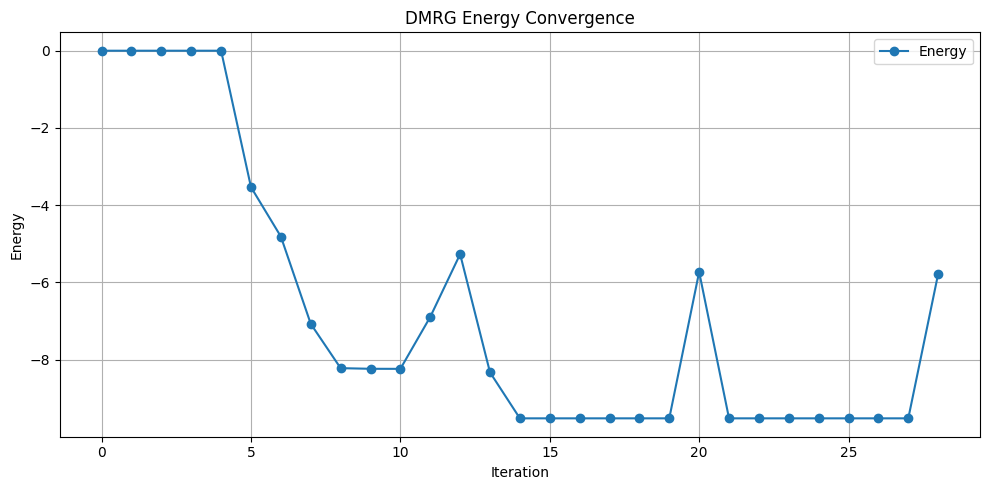


Energy values:
  Iteration 25: -9.51754097
  Iteration 26: -9.51754097
  Iteration 27: -9.51754097
  Iteration 28: -9.51754097
  Iteration 29: -5.77681374


In [15]:
L = 8
h = MPO_XY()
# h = MPO_AL_test(.1,.2,.3,.4,.5)
mps = MPS(L, d=h.d)
cont = CONT(mps, h) 
# FIX: Reduce k from 300 to something more reasonable for small systems
sys = dmrg(cont, chi=20, k=50)
obs = observables(mps)
mps.random()
cont.random()

# create folder out if not present
path_out = 'OUT/'
if os.path.isdir(path_out):
    shutil.rmtree(path_out)
os.mkdir(path_out)

EE = []
EE_pre = []
k = 0 

# First sweep
print("Running first sweep...")
for site, dir in tqdm(mps.first_sweep()):
    En, _, En_pre = sys.step2sites(site, dir=dir, stage='Final')
    EE.append(En)

print(f"First sweep complete. Energy: {EE[-1]:.6f}")

# Run a few DMRG sweeps (NOT infinite loop)
print("Running DMRG sweeps...")
num_sweeps = 3
for sweep_num in range(num_sweeps):
    print(f"\nSweep {sweep_num + 1}:")
    for site, dir in tqdm(mps.sweep()):
        En, _, En_pre = sys.step2sites(site, dir=dir, exc='off')
        EE.append(En)
        
    # Check convergence
    if len(EE) >= 2:
        energy_diff = abs(EE[-1] - EE[-2])
        print(f"Energy difference: {energy_diff:.2e}")
        if energy_diff < 1e-6:
            print("Converged!")
            break

print(f"\nFinal energy: {EE[-1]:.8f}")
print(f"Total energies computed: {len(EE)}")

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(EE[1:], marker='o', label='Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('DMRG Energy Convergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nEnergy values:")
for i, e in enumerate(EE[-5:]):
    print(f"  Iteration {len(EE)-5+i}: {e.real:.8f}")

In [1]:
"""
Tensor contraction with parallel/back-end options.

Backends:
- "numpy" (default): uses np.tensordot / np.einsum (may already be multithreaded via BLAS).
- "dask": uses dask.array to chunk/parallelize across cores (recommended for large arrays on CPU).
- "multiprocessing": simple row/chunk-level parallelism using multiprocessing.Pool.
- "torch": uses PyTorch and (if available) sends tensors to CUDA.

Notes:
- Dask requires `dask[array]` installed.
- PyTorch requires `torch`.
- Multiprocessing variant is simple and will copy arrays to workers unless you use shared_memory;
  it's intended as a clear example rather than a highly-optimized production solution.
"""
from typing import Optional, Sequence, Tuple, Union
import numpy as np

ArrayLike = Union[np.ndarray, Sequence[float], Sequence[int]]


class Tensor:
    def __init__(self, data: ArrayLike, labels: Optional[Sequence[str]] = None):
        self._data = np.array(data)
        self.labels = list(labels) if labels is not None else None

    @property
    def asarray(self) -> np.ndarray:
        return self._data

    def shape(self):
        return self._data.shape

    # Basic CPU contraction (uses numpy)
    def contract(self,
                 other: "Tensor",
                 axes: Optional[Union[int, Tuple[Sequence[int], Sequence[int]]]] = None,
                 einsum_subscript: Optional[str] = None) -> "Tensor":
        if einsum_subscript is not None:
            return Tensor(np.einsum(einsum_subscript, self._data, other._data))
        return Tensor(np.tensordot(self._data, other._data, axes=axes))

    # Parallelized contraction with backend choice
    def contract_parallel(self,
                          other: "Tensor",
                          axes: Optional[Union[int, Tuple[Sequence[int], Sequence[int]]]] = None,
                          einsum_subscript: Optional[str] = None,
                          backend: str = "dask",
                          dask_chunks: Optional[Union[str, Tuple[int, ...]]] = None,
                          n_workers: Optional[int] = None) -> "Tensor":
        """
        Contract self with other using a specified backend.

        Parameters
        - axes / einsum_subscript: same as contract()
        - backend: "numpy" | "dask" | "multiprocessing" | "torch"
        - dask_chunks: chunking scheme to pass to da.from_array (if backend == "dask")
        - n_workers: number of workers for multiprocessing or to influence chunking

        Returns: Tensor
        """
        if einsum_subscript is not None:
            # For einsum-style, try backend-specific paths where available.
            if backend == "numpy":
                return Tensor(np.einsum(einsum_subscript, self._data, other._data))
            if backend == "dask":
                try:
                    import dask.array as da
                except Exception as e:
                    raise RuntimeError("dask not installed") from e
                a = da.from_array(self._data, chunks=dask_chunks or "auto")
                b = da.from_array(other._data, chunks=dask_chunks or "auto")
                res = da.einsum(einsum_subscript, a, b)
                return Tensor(res.compute())
            if backend == "torch":
                try:
                    import torch
                except Exception as e:
                    raise RuntimeError("torch not installed") from e
                a = torch.as_tensor(self._data)
                b = torch.as_tensor(other._data)
                if torch.cuda.is_available():
                    a = a.cuda(); b = b.cuda()
                res = torch.einsum(einsum_subscript, a, b)
                return Tensor(res.cpu().numpy())
            # Multiprocessing fallback: just split along first axis of result
            # We'll fall through to the general multiprocessing path below.
        else:
            # non-einsum -> we'll delegate to backend-specific tensordot implementations
            pass

        # Backend-specific implementations for tensordot-like axes
        if backend == "numpy":
            return self.contract(other, axes=axes, einsum_subscript=einsum_subscript)

        if backend == "dask":
            try:
                import dask.array as da
            except Exception as e:
                raise RuntimeError("dask not installed") from e
            a = da.from_array(self._data, chunks=dask_chunks or "auto")
            b = da.from_array(other._data, chunks=dask_chunks or "auto")
            # Use tensordot if axes parametrized as in numpy.tensordot
            if einsum_subscript is not None:
                res = da.einsum(einsum_subscript, a, b)
            else:
                res = da.tensordot(a, b, axes=axes)
            return Tensor(res.compute())

        if backend == "torch":
            try:
                import torch
            except Exception as e:
                raise RuntimeError("torch not installed") from e
            a = torch.as_tensor(self._data)
            b = torch.as_tensor(other._data)
            if torch.cuda.is_available():
                a = a.cuda(); b = b.cuda()
            if einsum_subscript is not None:
                res = torch.einsum(einsum_subscript, a, b)
            else:
                # torch.tensordot available as torch.tensordot(a, b, dims)
                # need to convert axes to dims if axes provided like numpy
                if isinstance(axes, int):
                    # last axes of a and first of b
                    dim = axes
                    res = torch.tensordot(a, b, dims=dim)
                else:
                    res = torch.tensordot(a, b, dims=axes)
            return Tensor(res.cpu().numpy())

        if backend == "multiprocessing":
            # Simple chunked parallelization: split along first output axis (row-wise)
            # Works best when contraction reduces some axes and leaves a leading axis we can slice.
            import multiprocessing as mp

            # We'll handle the common case axes = 1 (matrix multiply A (M,K) @ B (K,N) -> (M,N))
            # and simple tensordot where last n axes of A with first n axes of B are contracted.
            if isinstance(axes, int):
                n = axes
                # For simplicity, only handle contracting last `n` axes of self with first `n` of other.
                # The output shape will have self.shape[:-n] + other.shape[n:]
                # We'll split along the first dimension of the output (if exists) => typically self.shape[0]
                out_leading = self._data.shape[0] if self._data.ndim > n else 1
                n_workers = n_workers or mp.cpu_count()
                # create slices of self along axis 0
                splits = max(1, min(n_workers, out_leading))
                idxs = np.array_split(np.arange(out_leading), splits)
                # Prepare worker function
                def worker(idx_slice):
                    if idx_slice.size == 0:
                        return None
                    # select the slice from self
                    sel = self._data[idx_slice, ...] if out_leading > 1 else self._data
                    part = np.tensordot(sel, other._data, axes=axes)
                    return (idx_slice, part)

                with mp.Pool(processes=splits) as pool:
                    results = pool.map(worker, idxs)
                # Combine results
                # initialize output by computing one slice shape
                pieces = [r for r in results if r is not None]
                # reconstruct in order
                if out_leading > 1:
                    # assume parts correspond to blocks along axis 0
                    ordered = sorted(pieces, key=lambda x: x[0][0])
                    parts = [p for _, p in ordered]
                    out = np.concatenate(parts, axis=0)
                else:
                    out = pieces[0][1]
                return Tensor(out)
            else:
                # axes is a pair of lists -- fallback to simple map over first axis of result
                # For clarity, just compute sequentially (user can use dask/torch for better parallelism)
                return Tensor(np.tensordot(self._data, other._data, axes=axes))

        raise ValueError(f"Unsupported backend: {backend}")

# Example usage:
if __name__ == "__main__":
    # small test matrices
    A = Tensor(np.random.rand(400, 800))
    B = Tensor(np.random.rand(800, 300))

    # 1) Use BLAS-backed numpy (may be multi-threaded already)
    C_np = A.contract_parallel(B, axes=1, backend="numpy")
    print("numpy result shape:", C_np.asarray().shape if hasattr(C_np, "asarray") else C_np.shape())

    # 2) Use dask (recommended for large arrays, requires dask[array])
    try:
        C_dask = A.contract_parallel(B, axes=1, backend="dask", dask_chunks=(100, 800))
        print("dask result shape:", C_dask.asarray().shape if hasattr(C_dask, "asarray") else C_dask.shape())
    except Exception as e:
        print("dask backend unavailable:", e)

    # 3) Use multiprocessing (simple)
    C_mp = A.contract_parallel(B, axes=1, backend="multiprocessing", n_workers=4)
    print("mp result shape:", C_mp.asarray().shape if hasattr(C_mp, "asarray") else C_mp.shape())

    # 4) Use torch if you have GPU (or CPU torch)
    try:
        C_t = A.contract_parallel(B, axes=1, backend="torch")
        print("torch result shape:", C_t.asarray().shape if hasattr(C_t, "asarray") else C_t.shape())
    except Exception as e:
        print("torch backend unavailable:", e)

TypeError: 'numpy.ndarray' object is not callable

In [2]:
"""
A small Tensor class with explicit contraction utilities.

Features:
- Wraps a numpy.ndarray
- contract(...) to contract with another Tensor using:
    - explicit axes (like numpy.tensordot)
    - an einsum-style subscript string (e.g. "ij,jk->ik")
- einsum(...) helper to run arbitrary np.einsum expressions involving multiple tensors
- convenience methods: reshape, transpose, asarray, copy
- lightweight label bookkeeping (optional): allow naming tensor axes for human-readable checks

This is intentionally minimal and pure-NumPy for clarity. For large-scale GPU work,
use PyTorch or JAX and adjust the implementation accordingly (swap np -> torch/jax).
"""
from typing import Iterable, List, Optional, Sequence, Tuple, Union
import numpy as np

ArrayLike = Union[np.ndarray, Sequence[float], Sequence[int]]


class Tensor:
    def __init__(self, data: ArrayLike, labels: Optional[Sequence[str]] = None):
        """
        Create a Tensor from array-like data.

        Args:
            data: array-like convertible to numpy.ndarray
            labels: optional sequence of axis labels (length must equal ndim)
        """
        self._data = np.array(data)
        if labels is not None:
            if len(labels) != self._data.ndim:
                raise ValueError("Number of labels must equal number of axes")
            self.labels = list(labels)
        else:
            self.labels = None

    @property
    def shape(self) -> Tuple[int, ...]:
        return self._data.shape

    @property
    def ndim(self) -> int:
        return self._data.ndim

    def asarray(self) -> np.ndarray:
        return self._data

    def copy(self) -> "Tensor":
        return Tensor(self._data.copy(), labels=(self.labels.copy() if self.labels else None))

    def reshape(self, *shape: int) -> "Tensor":
        return Tensor(self._data.reshape(*shape))

    def transpose(self, *axes: int) -> "Tensor":
        return Tensor(self._data.transpose(*axes))

    def __repr__(self) -> str:
        lab = f", labels={self.labels}" if self.labels else ""
        return f"Tensor(shape={self.shape}{lab})"

    # Primary contraction API
    def contract(
        self,
        other: "Tensor",
        axes: Optional[Union[int, Tuple[Sequence[int], Sequence[int]]]] = None,
        einsum_subscript: Optional[str] = None,
    ) -> "Tensor":
        """
        Contract self with other.

        Two main ways to specify the contraction:
        1) axes: same semantics as numpy.tensordot
            - If an integer n, contract over the last n axes of self and first n axes of other.
            - If a pair of sequences (axes_self, axes_other), they specify axis indices to sum over.
        2) einsum_subscript: an einsum specification string like "ij,jk->ik".
            - When provided, this takes precedence and is passed to np.einsum.

        Returns:
            Tensor wrapping the result array.
        """
        if einsum_subscript is not None:
            # accept either "ij,jk->ik" or inputs without arrow (->), still uses numpy.einsum
            # We need to build the argument like np.einsum(subscript, a, b)
            result = np.einsum(einsum_subscript, self._data, other._data)
            return Tensor(result)

        # fall back to numpy.tensordot semantics
        result = np.tensordot(self._data, other._data, axes=axes)
        return Tensor(result)

    def einsum(self, subscripts: str, *others: "Tensor") -> "Tensor":
        """
        General einsum wrapper allowing multiple tensors.

        Example: A.einsum("ij,jk,kl->il", B, C)
        """
        arrays = [self._data] + [t._data for t in others]
        result = np.einsum(subscripts, *arrays)
        return Tensor(result)

    # convenience shortcut for common operations
    def dot(self, other: "Tensor") -> "Tensor":
        """
        Matrix-vector or matrix-matrix multiply along last axis of self and second-to-last of other, similar to np.dot.
        For clarity, this uses einsum "ij,jk->ik" style when both are 2-D.
        """
        # Let numpy.dot handle generic arrays via tensordot behavior:
        return Tensor(np.dot(self._data, other._data))

    def trace(self, axis1: int = 0, axis2: int = 1) -> "Tensor":
        """
        Trace over two axes (default first two).
        """
        return Tensor(np.trace(self._data, axis1=axis1, axis2=axis2))

    # Basic arithmetic passthroughs
    def __add__(self, other):
        if isinstance(other, Tensor):
            return Tensor(self._data + other._data)
        return Tensor(self._data + other)

    def __sub__(self, other):
        if isinstance(other, Tensor):
            return Tensor(self._data - other._data)
        return Tensor(self._data - other)

    def __mul__(self, other):
        if isinstance(other, Tensor):
            return Tensor(self._data * other._data)
        return Tensor(self._data * other)

    def __matmul__(self, other: "Tensor") -> "Tensor":
        """
        Tensor @ Tensor delegates to np.matmul if shapes make sense.
        """
        return Tensor(self._data @ other._data)

    # helper to pretty-print small arrays
    def pretty(self, precision: int = 4) -> str:
        with np.printoptions(precision=precision, suppress=True):
            return np.array2string(self._data)

# Example usage and simple tests
if __name__ == "__main__":
    # Basic matrix multiplication via contract with axes=int
    A = Tensor([[1.0, 2.0], [3.0, 4.0]])   # shape (2,2)
    B = Tensor([[5.0, 6.0], [7.0, 8.0]])   # shape (2,2)
    C = A.contract(B, axes=1)  # last axis of A with first axis of B -> result shape (2,2)
    print("A @ B (using axes=1):\n", C.asarray() if hasattr(C, "asarray") else C)

    # Matrix multiply via einsum-subscript
    C2 = A.contract(B, einsum_subscript="ij,jk->ik")
    print("A @ B (using einsum):\n", C2.asarray() if hasattr(C2, "asarray") else C2)

    # Inner product of vectors (contract over the only axis of each)
    v = Tensor([1.0, 2.0, 3.0])
    w = Tensor([4.0, 5.0, 6.0])
    inner = v.contract(w, axes=1)  # axes=1 means last axis of v vs first axis of w -> scalar
    print("Inner product (v.w):", inner.asarray())

    # Contract over multiple axes: 3D tensors
    X = Tensor(np.arange(2*3*4).reshape(2,3,4))
    Y = Tensor(np.arange(4*3*2).reshape(4,3,2))
    # Contract axis 2 of X with axis 0 of Y (size 4) and axis 1 of X with axis 1 of Y (size 3)
    # Using explicit axes lists: axes=([2,1], [0,1]) -> remaining axes: X axis 0 and Y axis 2 -> shape (2,2)
    Z = X.contract(Y, axes=([2, 1], [0, 1]))
    print("Z.shape (expected (2,2)):", Z.shape)

    # Using einsum for the same contraction - name axes i,j,k and a,b,j -> contract j and k appropriately
    # For clarity we can write "ijk,kja->ia"
    Z2 = X.contract(Y, einsum_subscript="ijk,kja->ia")
    print("Z2.shape (expected (2,2)):", Z2.shape)

A @ B (using axes=1):
 [[19. 22.]
 [43. 50.]]
A @ B (using einsum):
 [[19. 22.]
 [43. 50.]]
Inner product (v.w): 32.0
Z.shape (expected (2,2)): (2, 2)
Z2.shape (expected (2,2)): (2, 2)


### test lanczos

In [ ]:
def lanczos(mat,k=100):
    k = min(k,mat.shape[0])

    vec = np.random.random(mat.shape[0])
    a = np.zeros(k)
    b = np.zeors(k-1)

    b0 = np.linalg.norm(vec)

    vec /= b0

    w = mat@psi

    a[0] = vec@w

    w -= a[-1]*vec

    for i in range(1,k):
        b.append()


